In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from statsmodels.tsa import stattools
import statsmodels

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# # ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (25,6)

In [2]:
raw_data = pd.read_csv('temp_data.txt', delimiter=',', skiprows=19)

In [3]:
raw_data

,SOUID,DATE,TG,Q_TG
0,111448,19510101,-40,0
1,111448,19510102,-14,0
2,111448,19510103,-12,0
3,111448,19510104,4,0
4,111448,19510105,25,0
...,...,...,...,...
25563,111448,20201227,16,0
25564,111448,20201228,28,0
25565,111448,20201229,23,0
25566,111448,20201230,25,0


In [4]:
raw_data.columns = ['id', 'date', 'temp','quality']
raw_data.head()

,id,date,temp,quality
0,111448,19510101,-40,0
1,111448,19510102,-14,0
2,111448,19510103,-12,0
3,111448,19510104,4,0
4,111448,19510105,25,0


In [5]:
raw_data['id'].nunique()

1

In [6]:
raw_data['id'].value_counts()

111448    25568
Name: id, dtype: int64

In [7]:
raw_data['quality'].value_counts()

0    25568
Name: quality, dtype: int64

In [8]:
raw_data.drop(['id', 'quality'], axis=1, inplace=True)
raw_data.head()

,date,temp
0,19510101,-40
1,19510102,-14
2,19510103,-12
3,19510104,4
4,19510105,25


In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   date    25568 non-null  int64
 1   temp    25568 non-null  int64
dtypes: int64(2)
memory usage: 399.6 KB


In [10]:
raw_data['date'] = raw_data['date'].astype(str)

raw_data['date'] = pd.to_datetime(raw_data['date'])

raw_data.head()

,date,temp
0,1951-01-01,-40
1,1951-01-02,-14
2,1951-01-03,-12
3,1951-01-04,4
4,1951-01-05,25


In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    25568 non-null  datetime64[ns]
 1   temp    25568 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 399.6 KB


In [12]:
data = raw_data.set_index('date')
data.head()

,temp
date,
1951-01-01,-40
1951-01-02,-14
1951-01-03,-12
1951-01-04,4
1951-01-05,25


In [13]:
data_subset = data.loc['1980': '1982']

data_subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 1980-01-01 to 1982-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   temp    1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB


In [14]:
#plot the time series
data['temp_c'] = data['temp']*0.1

<AxesSubplot:xlabel='date'>

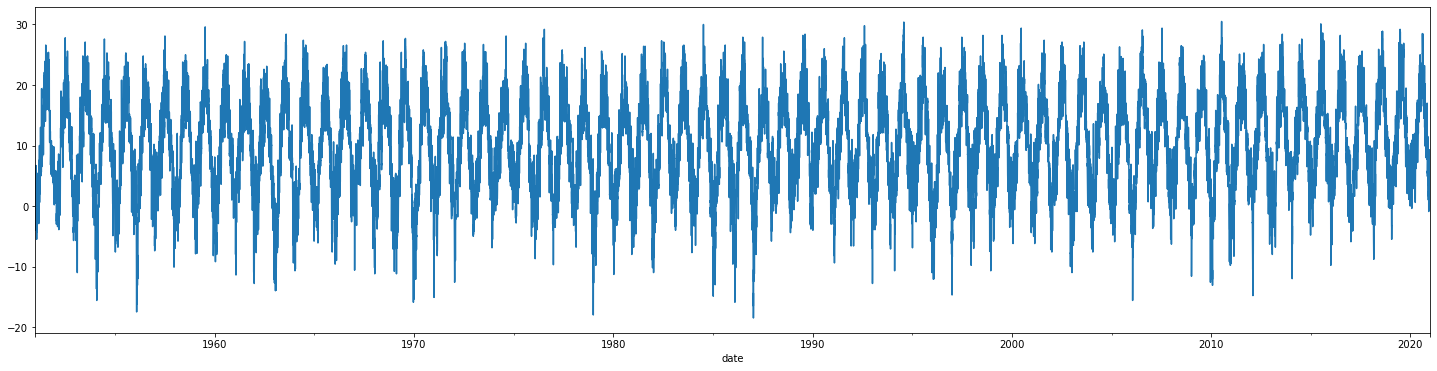

In [15]:
data['temp_c'].plot()

In [16]:
#devide into train and test

data_train = data.loc[:'2019']
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25202 entries, 1951-01-01 to 2019-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    25202 non-null  int64  
 1   temp_c  25202 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 590.7 KB


In [17]:
data_train.tail()

,temp,temp_c
date,,
2019-12-27,31,3.1
2019-12-28,13,1.3
2019-12-29,0,0.0
2019-12-30,45,4.5
2019-12-31,60,6.0


In [18]:
data_train.drop(['temp'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
data_train.to_csv('temp_train.csv')

In [20]:
data_test = data.loc['2020':]
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    366 non-null    int64  
 1   temp_c  366 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [21]:
data_test.drop(['temp'], axis=1, inplace=True)

In [22]:
data_test.to_csv('temp_test.csv')

In [23]:
#model the trend
data_train['timestep'] = list(range(len(data_train)))

/var/folders/fs/bmr1lyws1dx3sp07l0gytvmc0000gn/T/ipykernel_80495/2652361948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['timestep'] = list(range(len(data_train)))


In [24]:
data_train.head()

,temp_c,timestep
date,,
1951-01-01,-4.0,0
1951-01-02,-1.4,1
1951-01-03,-1.2,2
1951-01-04,0.4,3
1951-01-05,2.5,4


<AxesSubplot:xlabel='date'>

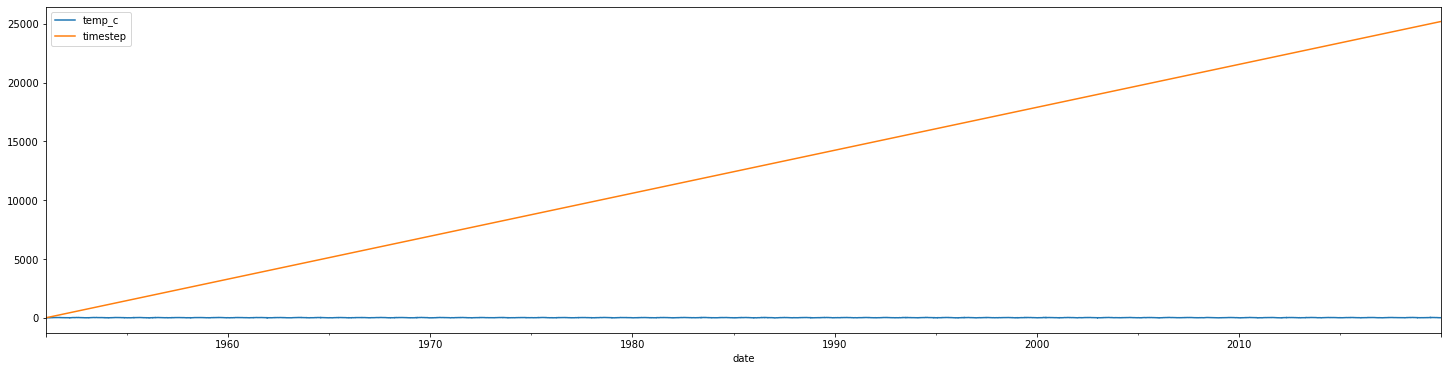

In [25]:
data_train.plot()

In [26]:
#model the seasonality
seasonal_dummies = pd.get_dummies(data_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(data_train.index)

data_train = data_train.join(seasonal_dummies)

In [27]:
data_train.head()

,temp_c,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1951-01-01,-4.0,0,0,0,0,0,0,0,0,0,0,0,0
1951-01-02,-1.4,1,0,0,0,0,0,0,0,0,0,0,0
1951-01-03,-1.2,2,0,0,0,0,0,0,0,0,0,0,0
1951-01-04,0.4,3,0,0,0,0,0,0,0,0,0,0,0
1951-01-05,2.5,4,0,0,0,0,0,0,0,0,0,0,0


In [28]:
X_train = data_train.drop(['timestep', 'temp_c'], axis=1)
y_train = data_train['temp_c']

In [29]:
X_train

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
1951-01-01,0,0,0,0,0,0,0,0,0,0,0
1951-01-02,0,0,0,0,0,0,0,0,0,0,0
1951-01-03,0,0,0,0,0,0,0,0,0,0,0
1951-01-04,0,0,0,0,0,0,0,0,0,0,0
1951-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,0,0,0,0,0,0,0,0,0,0,1


In [30]:
model = LinearRegression()

In [31]:
model.fit(X_train, y_train)

LinearRegression()

In [32]:
model.score(X_train, y_train)

0.7476790068436447

<AxesSubplot:xlabel='date', ylabel='temp_c'>

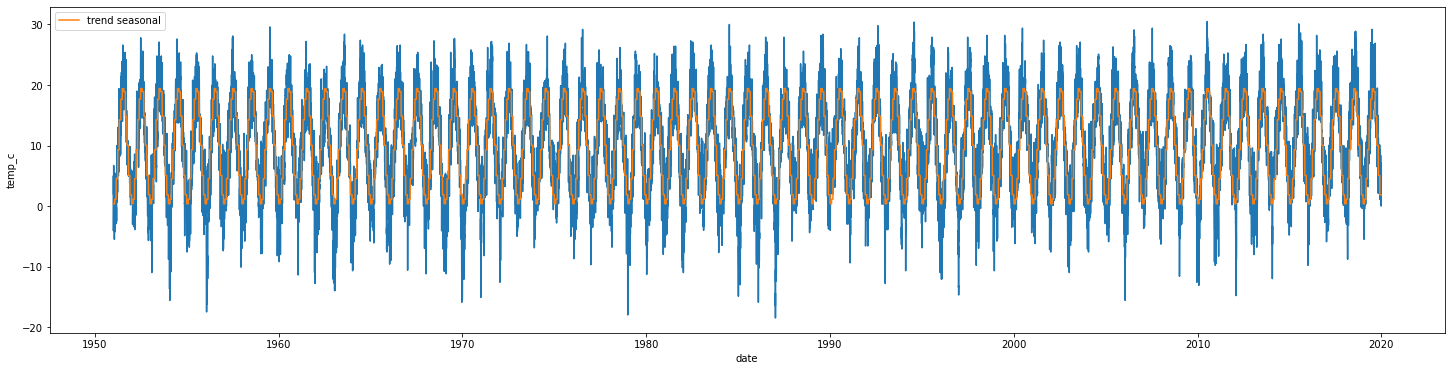

In [33]:
sns.lineplot(data=data_train.temp_c)
sns.lineplot(x=data_train.index, y=model.predict(X_train), label='trend seasonal')

In [34]:
#model the remainder
data_train['trend_seasonal'] = model.predict(X_train)
data_train['remainder'] = data_train['temp_c'] - data_train['trend_seasonal']

<AxesSubplot:xlabel='date', ylabel='remainder'>

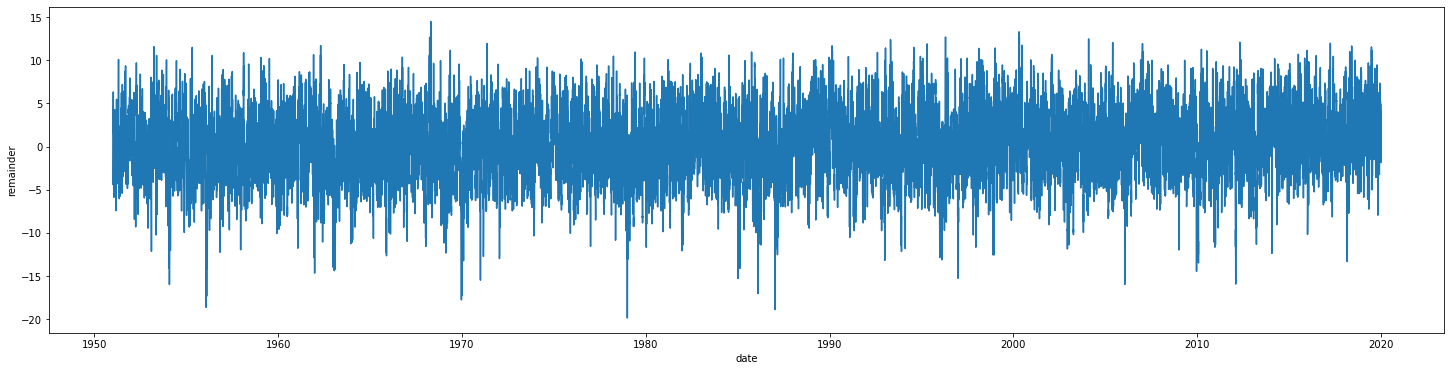

In [35]:
sns.lineplot(data=data_train.remainder)

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(data_train['temp_c'], model='additive')

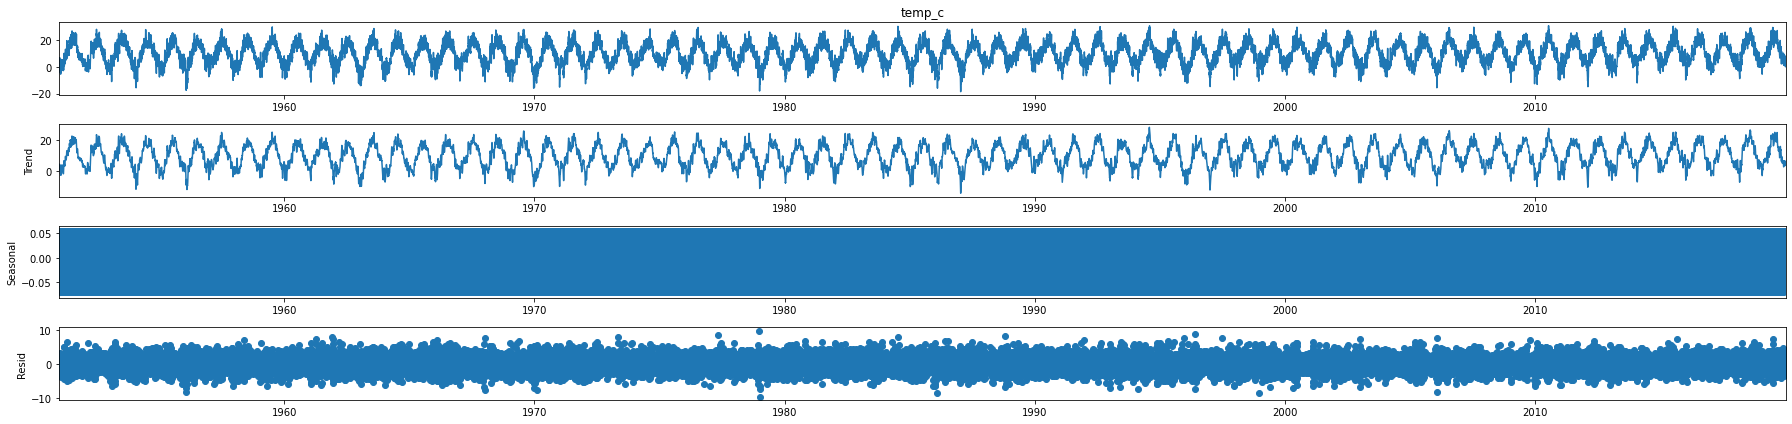

In [37]:
sd.plot()
None

In [38]:
X_train

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
1951-01-01,0,0,0,0,0,0,0,0,0,0,0
1951-01-02,0,0,0,0,0,0,0,0,0,0,0
1951-01-03,0,0,0,0,0,0,0,0,0,0,0
1951-01-04,0,0,0,0,0,0,0,0,0,0,0
1951-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,0,0,0,0,0,0,0,0,0,0,1


## Detect seasonality

In [39]:
data_train = pd.read_csv('temp_train.csv', parse_dates=True, index_col='date')

In [40]:
data_train['year'] = data_train.index.year
data_train['month'] = data_train.index.month
data_train['month_name'] = data_train.index.month_name()
data_train['day_of_year'] = data_train.index.dayofyear


data_train.head()

,temp_c,year,month,month_name,day_of_year
date,,,,,
1951-01-01,-4.0,1951,1,January,1
1951-01-02,-1.4,1951,1,January,2
1951-01-03,-1.2,1951,1,January,3
1951-01-04,0.4,1951,1,January,4
1951-01-05,2.5,1951,1,January,5


In [41]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25202 entries, 1951-01-01 to 2019-12-31
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp_c       25202 non-null  float64
 1   year         25202 non-null  int64  
 2   month        25202 non-null  int64  
 3   month_name   25202 non-null  object 
 4   day_of_year  25202 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.2+ MB


In [42]:
#remove 29.02 in leap years
data_train = data_train[~((data_train.index.month == 2) & (data_train.index.day == 29))]


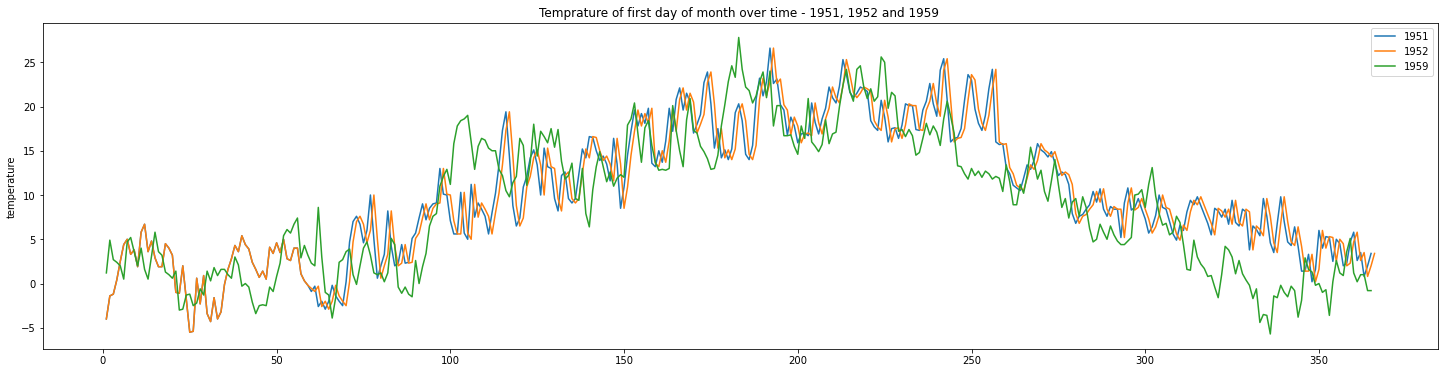

In [43]:
# comparing over multiple years

fig, ax = plt.subplots()

data_1951 = data_train[data_train['year']==1951]
data_1952 = data_train[data_train['year']==1952]
data_1959 = data_train[data_train['year']==1959]

# ax.plot(data_1951['month_name'], data_1951['temp_c'], label='1951')
# ax.plot(data_1952['month_name'], data_1952['temp_c'], label='1952')
# ax.plot(data_1959['month_name'], data_1959['temp_c'], label='1959')

ax.plot(data_1951['day_of_year'], data_1951['temp_c'], label='1951')
ax.plot(data_1952['day_of_year'], data_1951['temp_c'], label='1952')
ax.plot(data_1959['day_of_year'], data_1952['temp_c'], label='1959')


plt.title ("Temprature of first day of month over time - 1951, 1952 and 1959 ")
plt.ylabel("temperature")
plt.legend()
plt.show()

In [44]:
data_train

,temp_c,year,month,month_name,day_of_year
date,,,,,
1951-01-01,-4.0,1951,1,January,1
1951-01-02,-1.4,1951,1,January,2
1951-01-03,-1.2,1951,1,January,3
1951-01-04,0.4,1951,1,January,4
1951-01-05,2.5,1951,1,January,5
...,...,...,...,...,...
2019-12-27,3.1,2019,12,December,361
2019-12-28,1.3,2019,12,December,362
2019-12-29,0.0,2019,12,December,363


In [45]:
#model the seasonality
seasonal_dummies = pd.get_dummies(data_train.index.dayofyear,
                                  prefix='day_of_year',
                                  drop_first=True).set_index(data_train.index)

data_train = data_train.join(seasonal_dummies)

In [46]:
# now we fit another model which captures day of year seasonality

X = data_train.drop(['month', 'month_name', 'temp_c', 'year', 'day_of_year'], axis=1)  # features 
y = data_train['temp_c']

m_trend_seasonal = LinearRegression()  # includes month dummies and timestep

m_trend_seasonal.fit(X, y)  # fit the model

data_train['trend_seasonal'] = m_trend_seasonal.predict(X)  

data_train.head()

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_358,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal
date,,,,,,,,,,,,,,,,,,,,,
1951-01-01,-4.0,1951,1,January,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.353623
1951-01-02,-1.4,1951,1,January,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.695652
1951-01-03,-1.2,1951,1,January,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.442029
1951-01-04,0.4,1951,1,January,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.163768
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.256522


In [47]:
X

,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,day_of_year_10,day_of_year_11,...,day_of_year_357,day_of_year_358,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366
date,,,,,,,,,,,,,,,,,,,,,
1951-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1951-01-02,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1951-01-03,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1951-01-04,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1951-01-05,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2019-12-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2019-12-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [48]:
def plot_timeseries (df, title=" ", ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    
    df.plot()
    plt.title(title)
    if ylim:
        plt.ylim(ymin=0)
    plt.ylabel("temperature")
    plt.show()

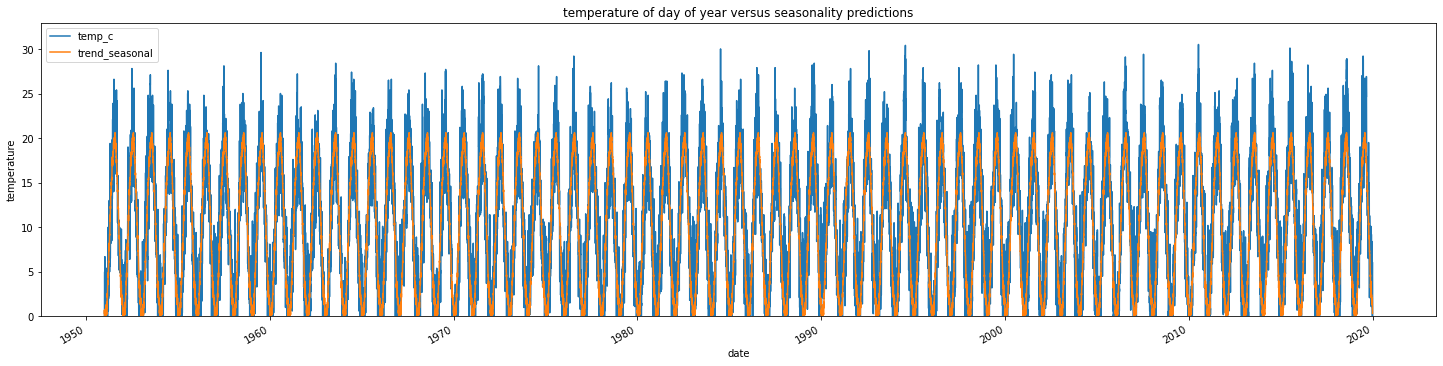

In [49]:
plot_timeseries(data_train[['temp_c', 'trend_seasonal']], 
                title = 'temperature of day of year versus seasonality predictions')

## Plot remainder over time

In [50]:
# calculating the error of our best model so far (trend + seasonality)
# extract remainder as a feature

data_train['remainder'] = data_train['temp_c'] - data_train['trend_seasonal']

data_train.head()

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,,,,,
1951-01-01,-4.0,1951,1,January,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.353623,-4.353623
1951-01-02,-1.4,1951,1,January,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.695652,-2.095652
1951-01-03,-1.2,1951,1,January,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.442029,-1.642029
1951-01-04,0.4,1951,1,January,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.163768,0.236232
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.256522,2.243478


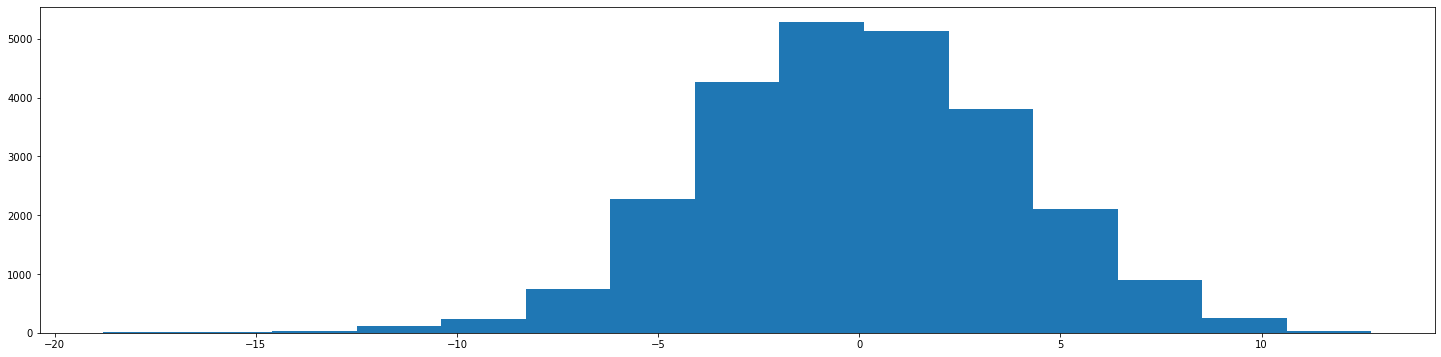

In [51]:
# plotting the distribution of the remainder

plt.hist(data_train['remainder'], bins=15)

plt.show()

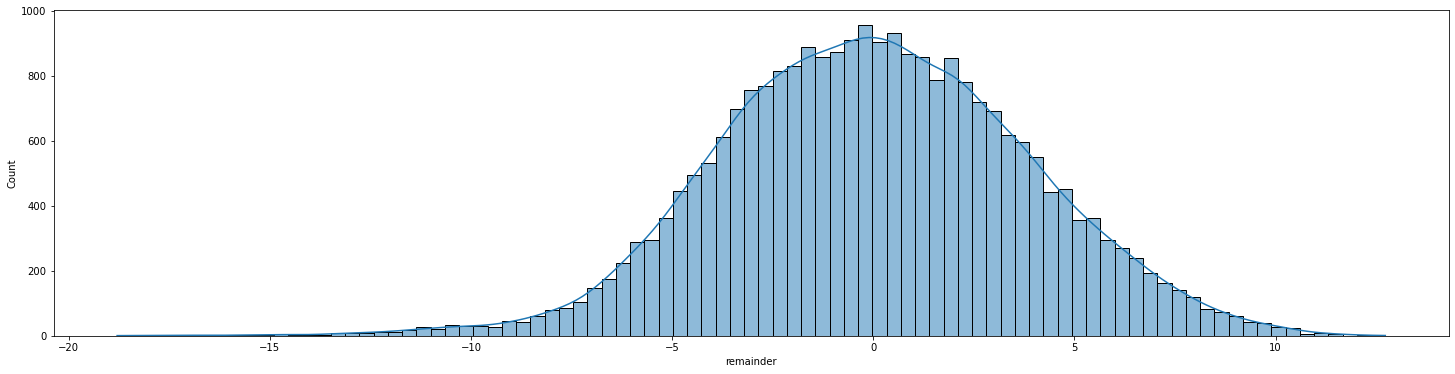

In [52]:
sns.histplot(data_train['remainder'], kde=True)

plt.show()

In [53]:
data_train['remainder'].std(), data_train['remainder'].mean()

(3.8148877065859907, 3.5777526574777726e-16)

In [54]:
# plot and compare with a random signal

data_train['random'] = np.random.normal(loc=0, scale=12, size=data_train.shape[0])

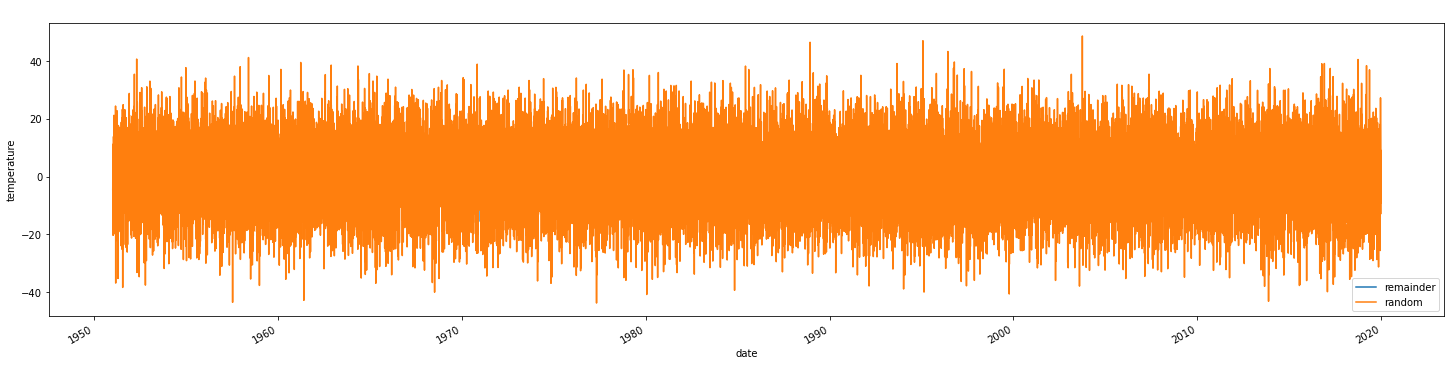

In [55]:
plot_timeseries(data_train[['remainder', 'random']], ylim=False)

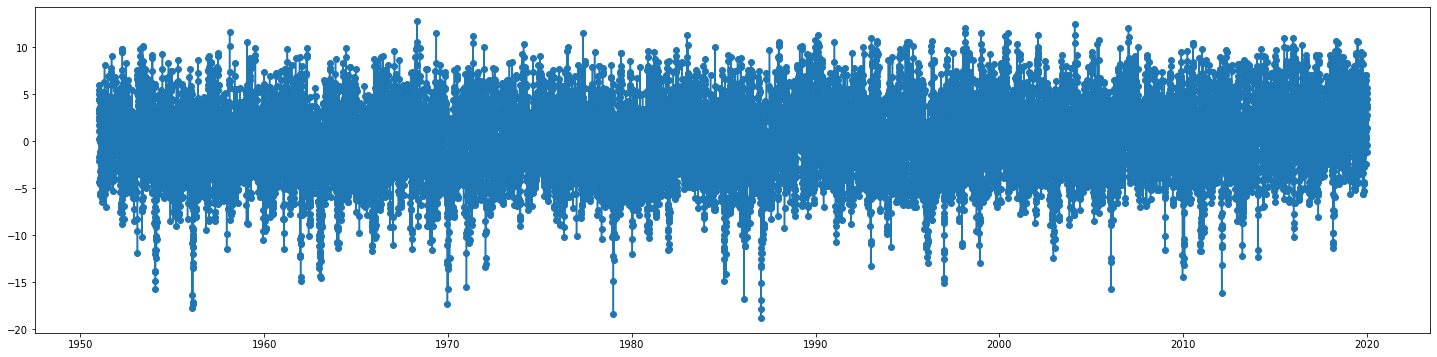

In [56]:
fig, ax = plt.subplots()
ax.plot(data_train.index, data_train['remainder'], marker='o')
plt.show()

## Creating a time lagged version of our data. 

In [57]:
remainder = data_train[['remainder']].copy()

remainder.head()

,remainder
date,
1951-01-01,-4.353623
1951-01-02,-2.095652
1951-01-03,-1.642029
1951-01-04,0.236232
1951-01-05,2.243478


In [58]:
#create time lagged feature of the reminder
remainder['lag1'] = remainder.shift(1) # shifting by one step == month

remainder.head()

,remainder,lag1
date,,
1951-01-01,-4.353623,NaN
1951-01-02,-2.095652,-4.353623
1951-01-03,-1.642029,-2.095652
1951-01-04,0.236232,-1.642029
1951-01-05,2.243478,0.236232


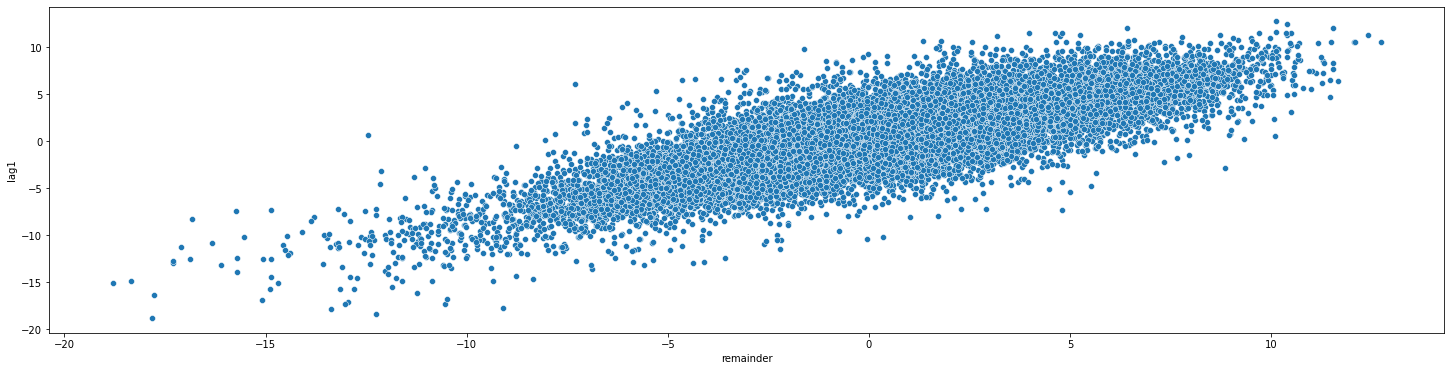

In [59]:
#calculate correlation between them
sns.scatterplot(x='remainder',  y='lag1', data=remainder);

plt.show()

In [60]:
remainder['remainder'].corr(remainder['lag1'])

0.8081179320802159

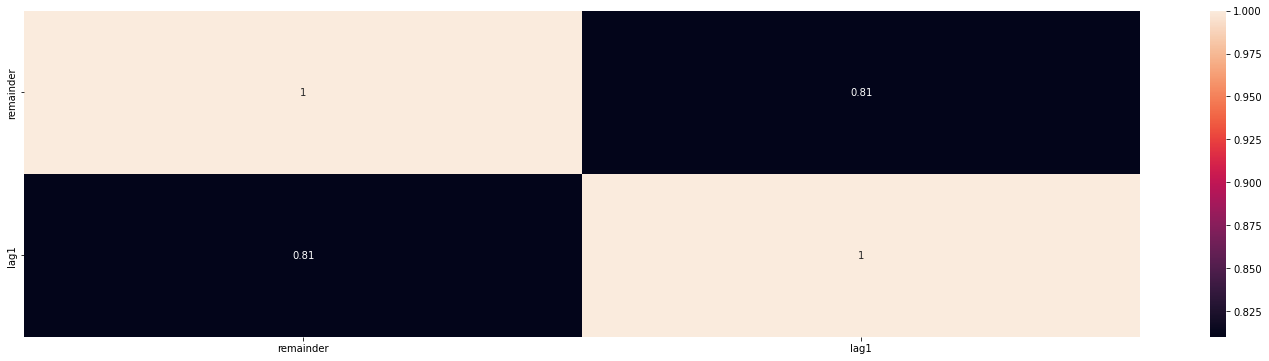

In [61]:
sns.heatmap(round(remainder.corr(), 2), annot=True)

plt.show()

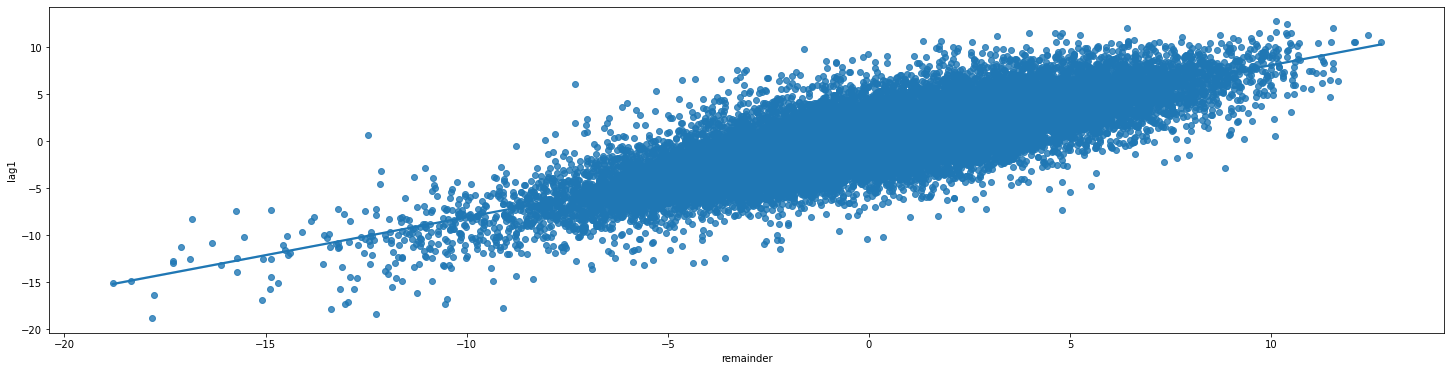

In [62]:
sns.regplot(x = remainder['remainder'], y = remainder['lag1'], fit_reg=True, scatter=True);

plt.show()

## Run an AR(1) on remainder series

In [63]:
remainder.head()

,remainder,lag1
date,,
1951-01-01,-4.353623,NaN
1951-01-02,-2.095652,-4.353623
1951-01-03,-1.642029,-2.095652
1951-01-04,0.236232,-1.642029
1951-01-05,2.243478,0.236232


In [64]:
remainder_copy = remainder.copy()

In [65]:
# we have to drop the NaN
remainder.dropna(inplace=True)

In [66]:
remainder.head()

,remainder,lag1
date,,
1951-01-02,-2.095652,-4.353623
1951-01-03,-1.642029,-2.095652
1951-01-04,0.236232,-1.642029
1951-01-05,2.243478,0.236232
1951-01-06,4.462319,2.243478


In [67]:
# simply a linear regression



X = remainder[['lag1']]  # only feature is the lagged remainder
y = remainder['remainder']

m_ar = LinearRegression()

m_ar.fit(X, y)

remainder['prediction_ar1'] = m_ar.predict(X)

remainder.head()

,remainder,lag1,prediction_ar1
date,,,
1951-01-02,-2.095652,-4.353623,-3.517949
1951-01-03,-1.642029,-2.095652,-1.693210
1951-01-04,0.236232,-1.642029,-1.326622
1951-01-05,2.243478,0.236232,0.191261
1951-01-06,4.462319,2.243478,1.813382


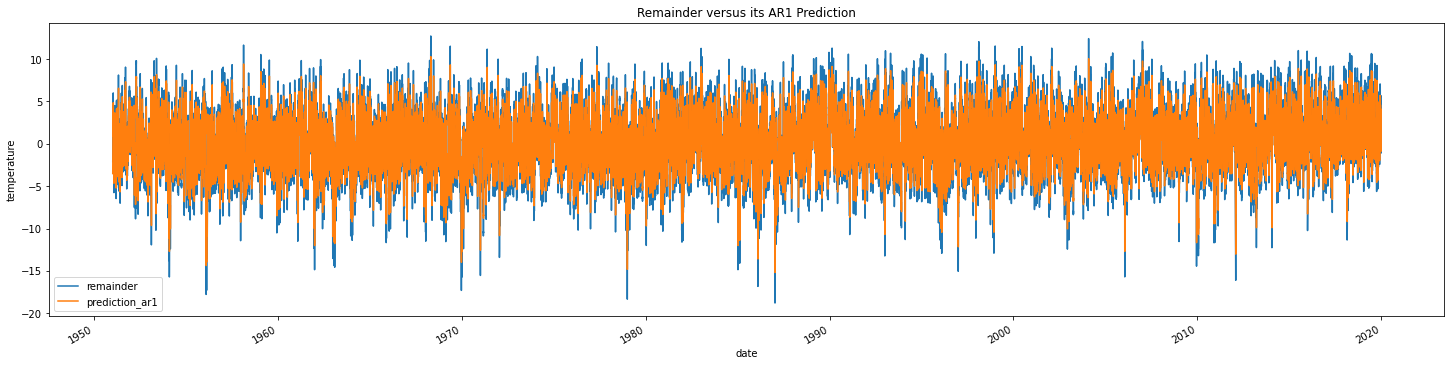

In [68]:
# let's plot the remainder and its AR(1) prediction

plot_timeseries(remainder[['remainder', 'prediction_ar1']], title="Remainder versus its AR1 Prediction", ylim=False)

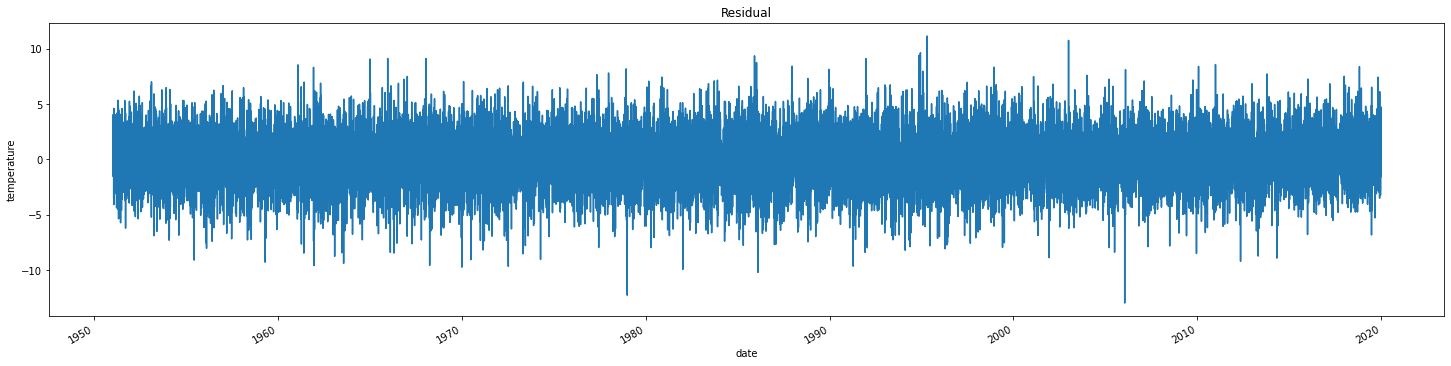

In [69]:
#look at the residuals of this ar1 model 
remainder['residual'] = remainder['remainder'] - remainder['prediction_ar1']

plot_timeseries(remainder['residual'], title="Residual", ylim=False)

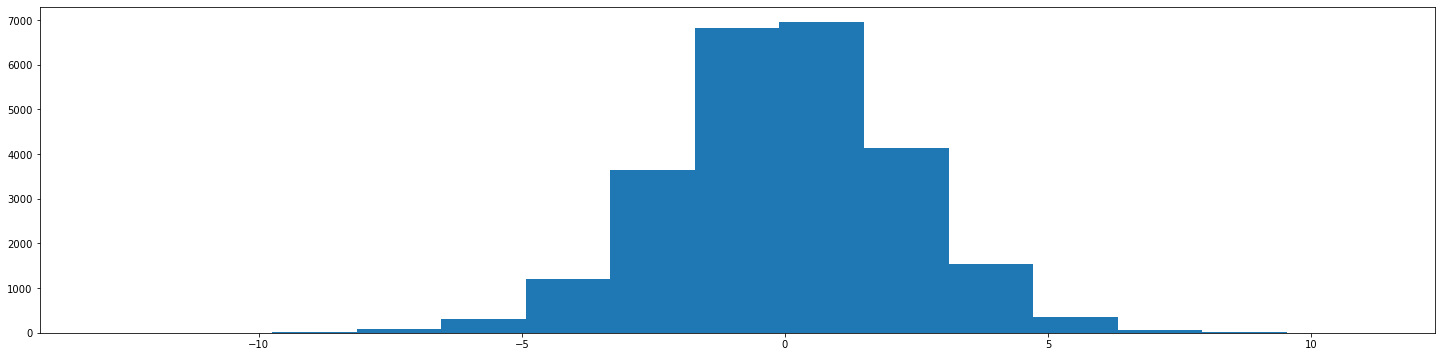

In [70]:
plt.hist(remainder['residual'], bins=15)

plt.show()

In [71]:
remainder['residual'].mean()

1.867594036500164e-16

## Should we take additional lags into consideration ? AR(2) model ?

In [72]:
remainder_copy['lag2'] = remainder['lag1'].shift(1)

In [73]:
remainder_copy.head()

,remainder,lag1,lag2
date,,,
1951-01-01,-4.353623,NaN,NaN
1951-01-02,-2.095652,-4.353623,NaN
1951-01-03,-1.642029,-2.095652,-4.353623
1951-01-04,0.236232,-1.642029,-2.095652
1951-01-05,2.243478,0.236232,-1.642029


In [74]:
remainder_copy['remainder'].corr(remainder_copy['lag2'])

0.6052614943630996

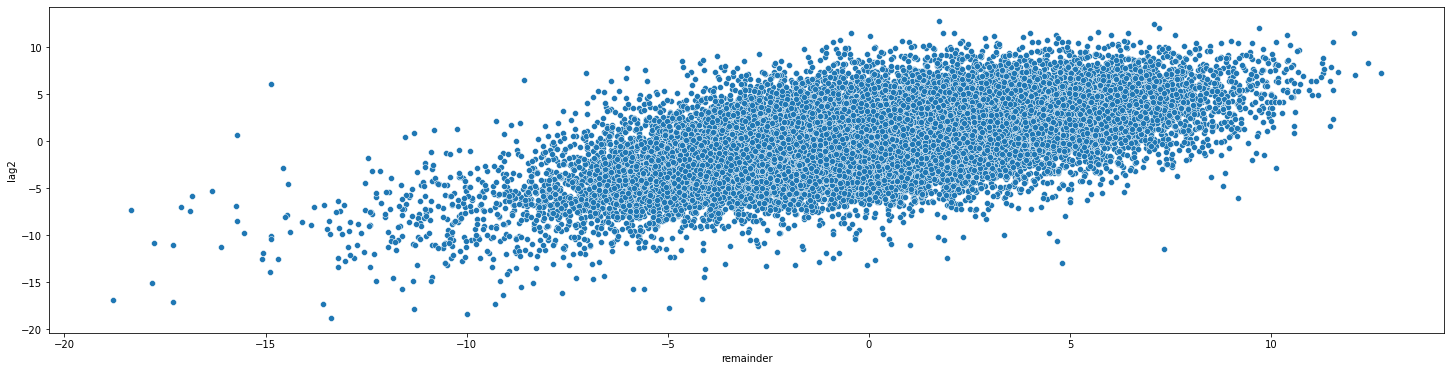

In [75]:
sns.scatterplot(x='remainder',  y='lag2', data=remainder_copy);

plt.show()

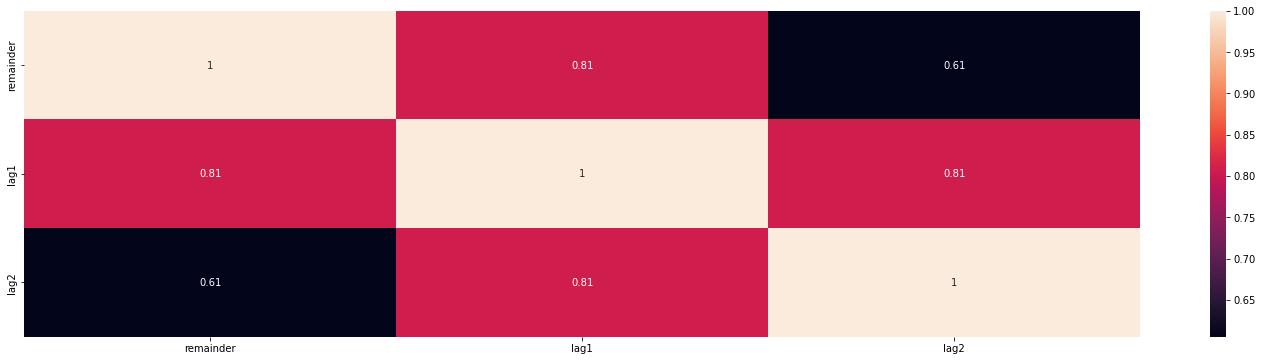

In [76]:
sns.heatmap(round(remainder_copy[['remainder', 'lag1', 'lag2']].corr(), 4), annot=True)

plt.show()

In [77]:
0.81*0.81

0.6561000000000001

## Tools to find out how many lags to include in our AR model

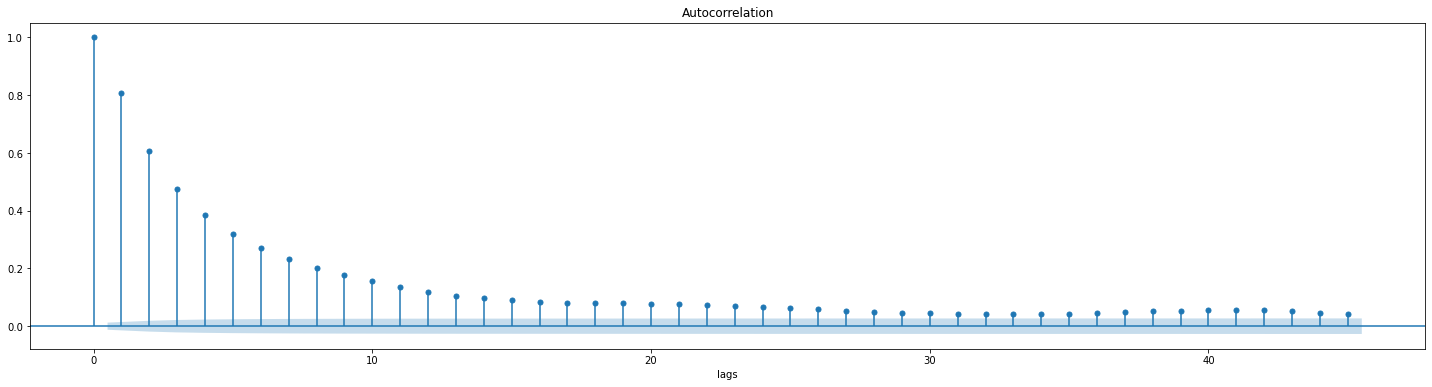

In [78]:
# we can plot auto-correlation with stats model

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(remainder['remainder'])
plt.xlabel('lags');

plt.show()

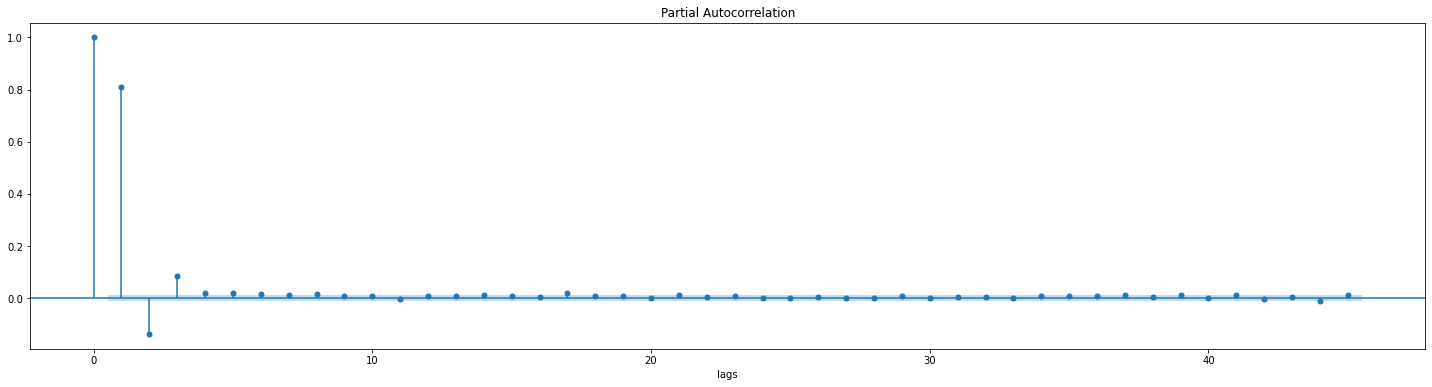

In [79]:
#partial auto-correlation 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(remainder['remainder'])
plt.xlabel('lags');

plt.show()

In [80]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [81]:
# inputs are time series as a pandas series and a max lag

selected_order = ar_select_order(remainder_copy['remainder'], maxlag = 12) 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [82]:
selected_order.ar_lags

array([1, 2, 3, 4])

In [83]:
stats_ar4 = AutoReg(remainder_copy['remainder'], lags=4, old_names=False).fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [84]:
stats_ar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                25185
Model:                     AutoReg(4)   Log Likelihood              -55780.998
Method:               Conditional MLE   S.D. of innovations              2.217
Date:                Fri, 28 Jan 2022   AIC                              1.593
Time:                        14:21:55   BIC                              1.595
Sample:                             4   HQIC                             1.594
                                25185                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.014      0.015      0.988      -0.027       0.028
remainder.L1     0.9294      0.006    147.511      0.000       0.917       0.942
remainder.L2    -0.2112      0.009    -24.575      0.000      -0.228      -0.194
remainder.L3     0.0658      0.009      7.657      0.000       0.049       0.083
remainder.L4     0.0202      0.006      3.204      0.001       0.008       0.033
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2389           -0.0000j            1.2389           -0.0000
AR.2            0.8944           -2.3579j            2.5218           -0.1923
AR.3            0.8944           +2.3579j            2.5218            0.1923
AR.4           -6.2869           -0.0000j            6.2869           -0.5000
-----------------------------------------------------------------------------
"""

In [85]:
stats_ar4.predict()

date
1951-01-01   NaN
1951-01-02   NaN
1951-01-03   NaN
1951-01-04   NaN
1951-01-05   NaN
              ..
2019-12-27   NaN
2019-12-28   NaN
2019-12-29   NaN
2019-12-30   NaN
2019-12-31   NaN
Length: 25185, dtype: float64

In [86]:
data_train

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random
date,,,,,,,,,,,,,,,,,,,,,
1951-01-01,-4.0,1951,1,January,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.353623,-4.353623,-4.604725
1951-01-02,-1.4,1951,1,January,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0.695652,-2.095652,4.580965
1951-01-03,-1.2,1951,1,January,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0.442029,-1.642029,-10.632179
1951-01-04,0.4,1951,1,January,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0.163768,0.236232,3.771228
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0.256522,2.243478,-11.686035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.1,2019,12,December,361,0,0,0,0,0,...,0,1,0,0,0,0,0,1.652174,1.447826,9.157182
2019-12-28,1.3,2019,12,December,362,0,0,0,0,0,...,0,0,1,0,0,0,0,1.697101,-0.397101,-9.144273
2019-12-29,0.0,2019,12,December,363,0,0,0,0,0,...,0,0,0,1,0,0,0,1.114493,-1.114493,-4.532187


In [87]:
remainder['prediction_ar1']

date
1951-01-02   -3.517949
1951-01-03   -1.693210
1951-01-04   -1.326622
1951-01-05    0.191261
1951-01-06    1.813382
                ...   
2019-12-27    2.290063
2019-12-28    1.170390
2019-12-29   -0.320556
2019-12-30   -0.900303
2019-12-31    3.108736
Name: prediction_ar1, Length: 25184, dtype: float64

In [88]:
data_train['lag4'] = data_train['remainder'].shift(4)

data_train.head()

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4
date,,,,,,,,,,,,,,,,,,,,,
1951-01-01,-4.0,1951,1,January,1,0,0,0,0,0,...,0,0,0,0,0,0,0.353623,-4.353623,-4.604725,NaN
1951-01-02,-1.4,1951,1,January,2,1,0,0,0,0,...,0,0,0,0,0,0,0.695652,-2.095652,4.580965,NaN
1951-01-03,-1.2,1951,1,January,3,0,1,0,0,0,...,0,0,0,0,0,0,0.442029,-1.642029,-10.632179,NaN
1951-01-04,0.4,1951,1,January,4,0,0,1,0,0,...,0,0,0,0,0,0,0.163768,0.236232,3.771228,NaN
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0,0.256522,2.243478,-11.686035,-4.353623


In [89]:
# drop na
data_train.dropna(inplace=True)

data_train.head()

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4
date,,,,,,,,,,,,,,,,,,,,,
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0,0.256522,2.243478,-11.686035,-4.353623
1951-01-06,4.4,1951,1,January,6,0,0,0,0,1,...,0,0,0,0,0,0,-0.062319,4.462319,-4.026039,-2.095652
1951-01-07,5.0,1951,1,January,7,0,0,0,0,0,...,0,0,0,0,0,0,-0.036232,5.036232,-20.140637,-1.642029
1951-01-08,3.3,1951,1,January,8,0,0,0,0,0,...,0,0,0,0,0,0,0.357971,2.942029,0.044489,0.236232
1951-01-09,3.8,1951,1,January,9,0,0,0,0,0,...,0,0,0,0,0,0,0.424638,3.375362,8.555126,2.243478


## Train full linear auto-regression

In [90]:
# define our new X and y and instantiate model

X = data_train.drop(['temp_c', 'trend_seasonal', 'remainder', 'month', 'month_name', 'random', 'year'], axis=1)
y = data_train['temp_c']

m_full = LinearRegression()

In [91]:
X.head()

,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,day_of_year_10,...,day_of_year_358,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,lag4
date,,,,,,,,,,,,,,,,,,,,,
1951-01-05,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-4.353623
1951-01-06,6,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.095652
1951-01-07,7,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.642029
1951-01-08,8,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.236232
1951-01-09,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2.243478


In [92]:
# train model and add predictions on training data
m_full.fit(X,y)

data_train['predictions_full'] = m_full.predict(X)
data_train.head()

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,,
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0.256522,2.243478,-11.686035,-4.353623,-1.424733
1951-01-06,4.4,1951,1,January,6,0,0,0,0,1,...,0,0,0,0,0,-0.062319,4.462319,-4.026039,-2.095652,-0.871604
1951-01-07,5.0,1951,1,January,7,0,0,0,0,0,...,0,0,0,0,0,-0.036232,5.036232,-20.140637,-1.642029,-0.670340
1951-01-08,3.3,1951,1,January,8,0,0,0,0,0,...,0,0,0,0,0,0.357971,2.942029,0.044489,0.236232,0.449198
1951-01-09,3.8,1951,1,January,9,0,0,0,0,0,...,0,0,0,0,0,0.424638,3.375362,8.555126,2.243478,1.291010


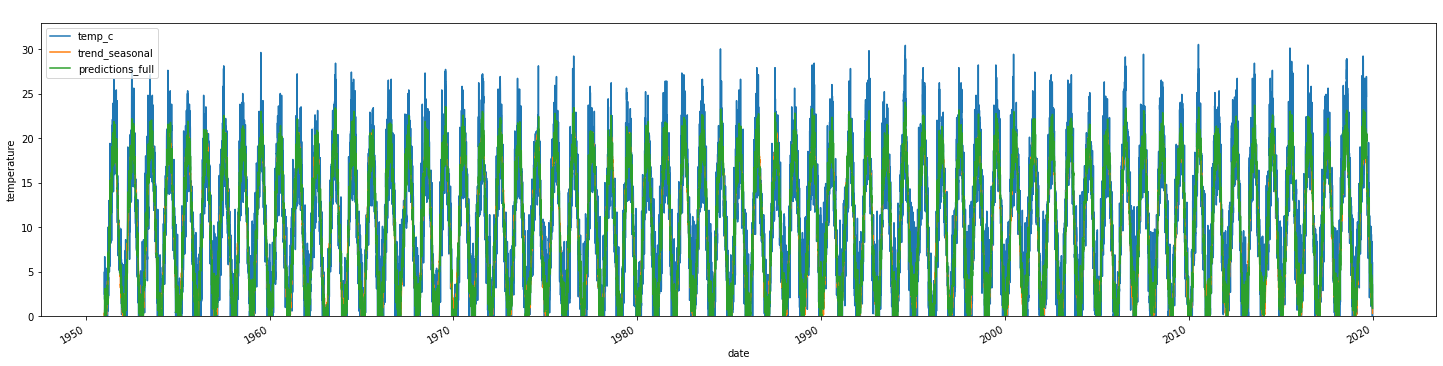

In [93]:
# plot target and predictions

plot_timeseries(data_train[['temp_c', 'trend_seasonal', 'predictions_full']])

In [94]:
# extracting full model coefficients after the training 

pd.DataFrame(m_full.coef_.reshape(1,367), columns=X.columns)

,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,day_of_year_10,...,day_of_year_358,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,lag4
0,0.041742,0.087352,-0.092165,-0.588893,-0.409865,-0.770448,-0.786103,-0.433643,-0.408719,-0.654809,...,-13.718857,-13.470744,-13.418284,-13.874519,-13.871334,-14.495685,-14.998297,-15.353083,-15.747939,0.386174


In [95]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5) # instanciate the class and give the k as input

time_cv = ts_split.split(X, y) # this is a python generator

In [96]:
# let's see how that works

# Split the training data into folds
for i, (train_index, validation_index) in enumerate(time_cv):
    print("The training data for iteration #{} are the observations steps  = {}".format(i+1, train_index))
    print("size of training data = {}".format(len(train_index)))
    print("The validation data for iteration #{} are the observations steps = {}".format(i+1, validation_index))
    print("size of validation data = {}".format(len(validation_index)))

The training data for iteration #1 are the observations steps  = [   0    1    2 ... 4198 4199 4200]
size of training data = 4201
The validation data for iteration #1 are the observations steps = [4201 4202 4203 ... 8394 8395 8396]
size of validation data = 4196
The training data for iteration #2 are the observations steps  = [   0    1    2 ... 8394 8395 8396]
size of training data = 8397
The validation data for iteration #2 are the observations steps = [ 8397  8398  8399 ... 12590 12591 12592]
size of validation data = 4196
The training data for iteration #3 are the observations steps  = [    0     1     2 ... 12590 12591 12592]
size of training data = 12593
The validation data for iteration #3 are the observations steps = [12593 12594 12595 ... 16786 16787 16788]
size of validation data = 4196
The training data for iteration #4 are the observations steps  = [    0     1     2 ... 16786 16787 16788]
size of training data = 16789
The validation data for iteration #4 are the observatio

In [97]:
for i, (train_index, validation_index) in enumerate(time_cv):
    print("The training data for iteration #{} are the observations steps  = {}".format(i+1, train_index))
    print("size of training data = {}".format(len(train_index)))
    print("The validation data for iteration #{} are the observations steps = {}".format(i+1, validation_index))
    print("size of validation data = {}".format(len(validation_index)))
    

In [98]:
# cross validate model and read scores 
time_cv = ts_split.split(X, y)

estimator = LinearRegression() # instanciate 

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.79920551 0.78107844 0.7795644  0.78530647 0.79839641]
0.7887102459807698


## Apply our trained model on test data

In [99]:
data_test = pd.read_csv("temp_test.csv", parse_dates=True, index_col='date')

print(data_test.head())

print(data_test.shape)

            temp_c
date              
2020-01-01     2.7
2020-01-02     0.9
2020-01-03     4.6
2020-01-04     4.2
2020-01-05     1.8
(366, 1)


In [100]:
#remove 29.02 in leap years
# data_test = data_test[~((data_test.index.month == 2) & (data_test.index.day == 29))]

In [101]:
print(data_test.shape)

(366, 1)


In [102]:
data_test

,temp_c
date,
2020-01-01,2.7
2020-01-02,0.9
2020-01-03,4.6
2020-01-04,4.2
2020-01-05,1.8
...,...
2020-12-27,1.6
2020-12-28,2.8
2020-12-29,2.3


## add seasonality prediction

In [103]:
#add day of year
data_test['day_of_year'] = data_test.index.dayofyear

In [104]:
#model the seasonality
seasonal_dummies = pd.get_dummies(data_test.index.dayofyear,
                                  prefix='day_of_year',
                                  drop_first=True).set_index(data_test.index)

data_test = data_test.join(seasonal_dummies)

In [105]:
data_test

,temp_c,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,...,day_of_year_357,day_of_year_358,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0.9,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,4.6,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,4.2,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-05,1.8,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.6,362,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-12-28,2.8,363,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-12-29,2.3,364,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [106]:
# now we fit another model which captures day of year seasonality

X_test = data_test.drop(['temp_c','day_of_year'], axis=1)  # features 
y_test = data_test['temp_c']

data_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)  

data_test.head()

,temp_c,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,...,day_of_year_358,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.353623
2020-01-02,0.9,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.695652
2020-01-03,4.6,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.442029
2020-01-04,4.2,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.163768
2020-01-05,1.8,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.256522


In [107]:
# calculating the error of our best model so far (trend + seasonality)
# extract remainder as a feature

data_test['remainder'] = data_test['temp_c'] - data_test['trend_seasonal']

data_test.head()

,temp_c,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,...,day_of_year_359,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.353623,2.346377
2020-01-02,0.9,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.695652,0.204348
2020-01-03,4.6,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.442029,4.157971
2020-01-04,4.2,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.163768,4.036232
2020-01-05,1.8,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.256522,1.543478


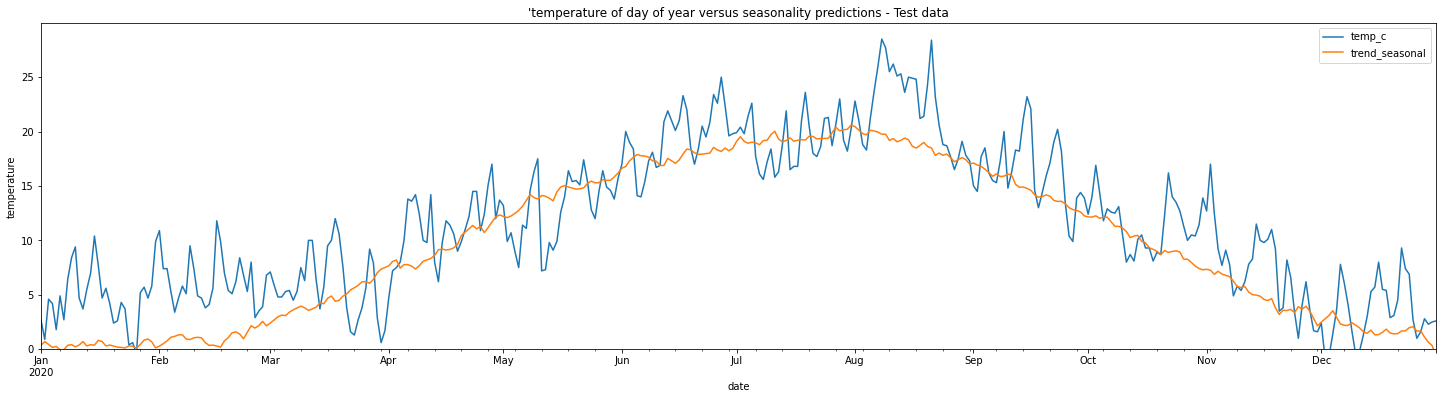

In [108]:
# plot

plot_timeseries(data_test[['temp_c', 'trend_seasonal']], 
                title="'temperature of day of year versus seasonality predictions - Test data")

### Calculate remainder and add lag1-4

In [109]:
data_test['remainder'] = data_test['temp_c'] - data_test['trend_seasonal']

# Create the lagged variable
data_test['lag4'] = data_test['remainder'].shift(4)

data_test.head()

,temp_c,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,...,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,lag4
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.353623,2.346377,NaN
2020-01-02,0.9,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.695652,0.204348,NaN
2020-01-03,4.6,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.442029,4.157971,NaN
2020-01-04,4.2,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.163768,4.036232,NaN
2020-01-05,1.8,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.256522,1.543478,2.346377


In [110]:
data_train.tail()

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,,
2019-12-27,3.1,2019,12,December,361,0,0,0,0,0,...,0,0,0,0,0,1.652174,1.447826,9.157182,5.120290,3.629495
2019-12-28,1.3,2019,12,December,362,0,0,0,0,0,...,1,0,0,0,0,1.697101,-0.397101,-9.144273,4.517391,3.441599
2019-12-29,0.0,2019,12,December,363,0,0,0,0,0,...,0,1,0,0,0,1.114493,-1.114493,-4.532187,3.527536,2.476734
2019-12-30,4.5,2019,12,December,364,0,0,0,0,0,...,0,0,1,0,0,0.653623,3.846377,-3.889361,2.833333,1.747782
2019-12-31,6.0,2019,12,December,365,0,0,0,0,0,...,0,0,0,1,0,0.340580,5.659420,-8.943730,1.447826,0.899692


### Use trained full model to predict temperature

In [111]:
# must fill NaN

data_test.loc['2020-01-01', 'lag4'] = data_train.loc['2019-12-28', 'remainder']
data_test.loc['2020-01-02', 'lag4'] = data_train.loc['2019-12-29', 'remainder']
data_test.loc['2020-01-03', 'lag4'] = data_train.loc['2019-12-30', 'remainder']
data_test.loc['2020-01-04', 'lag4'] = data_train.loc['2019-12-31', 'remainder']

data_test.head()

,temp_c,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,...,day_of_year_360,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,lag4
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.353623,2.346377,-0.397101
2020-01-02,0.9,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.695652,0.204348,-1.114493
2020-01-03,4.6,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.442029,4.157971,3.846377
2020-01-04,4.2,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.163768,4.036232,5.659420
2020-01-05,1.8,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.256522,1.543478,2.346377


In [112]:
# make full model predictions

X_test = data_test.drop(['temp_c', 'trend_seasonal', 'remainder'], axis=1)
# Create the predictions
data_test['predictions_full'] = m_full.predict(X_test)

data_test.head()

,temp_c,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,...,day_of_year_361,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.353623,2.346377,-0.397101,0.346067
2020-01-02,0.9,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.695652,0.204348,-1.114493,0.198124
2020-01-03,4.6,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.442029,4.157971,3.846377,1.976105
2020-01-04,4.2,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.163768,4.036232,5.659420,2.221269
2020-01-05,1.8,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.256522,1.543478,2.346377,1.162631


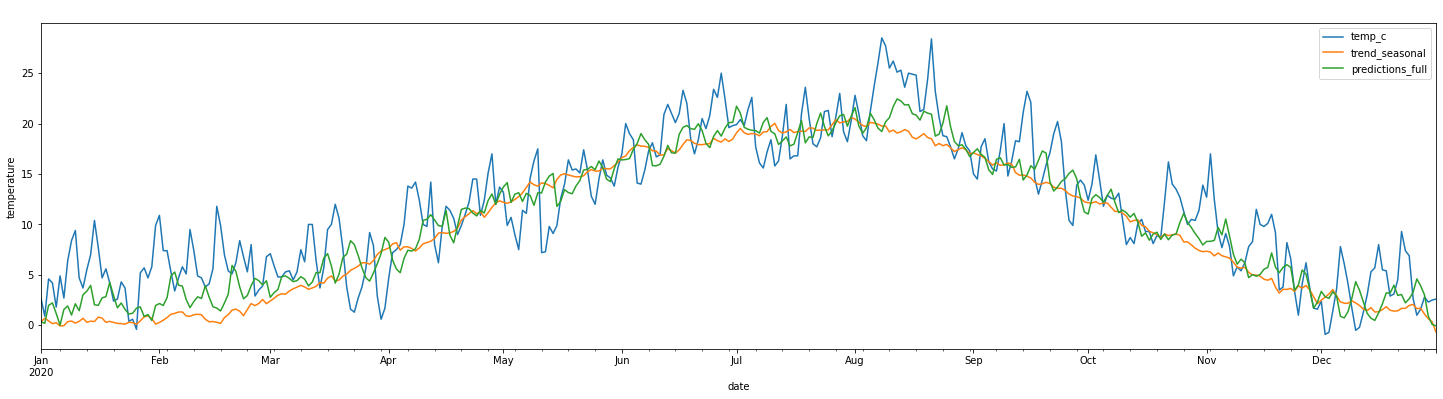

In [113]:
plot_timeseries(data_test[['temp_c', 'trend_seasonal', 'predictions_full']], ylim=False)

In [114]:
# let's check R squared score

print(r2_score(data_test['temp_c'], data_test['trend_seasonal']))  # the score of the trend and season. model

print(r2_score(data_test['temp_c'], data_test['predictions_full'])) # score of the full model

0.6863170858063716
0.7510420655082297


### ARIMA model

In [115]:
# apply the augmented Dicky-Fuller stationarity test

# recap: The null hypothesis is that the time series is NOT-stationary
# i.e. a small p value, less than 0.05, means that you have a stationary series

def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=1; CI=99%) 
            {round(levels['5%'],2)} (p=5; CI=95%)
            {round(levels['10%'],2)} (p=10 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [116]:
print_adf(data_train['remainder'])

   
            adf: -28.95
            p: 0.0 
            used lag: 16 
            number of observations: 25164
            -3.43 (p=1; CI=99%) 
            -2.86 (p=5; CI=95%)
            -2.57 (p=10 CI=90%) 
            information criterion (AIC): 111341.4566057763
            


In [117]:
from pmdarima.arima import auto_arima  

In [118]:
# ARIMA(p,d,q)

# p = number of AR lags
# q = number of MA lags
# d = the order of integration

auto_arima_model = auto_arima(data_train['remainder'], start_p=0, start_q=0, max_p=10, max_q=10)

In [119]:
auto_arima_model

ARIMA(order=(0, 1, 8), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [120]:
data_train

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,,
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0.256522,2.243478,-11.686035,-4.353623,-1.424733
1951-01-06,4.4,1951,1,January,6,0,0,0,0,1,...,0,0,0,0,0,-0.062319,4.462319,-4.026039,-2.095652,-0.871604
1951-01-07,5.0,1951,1,January,7,0,0,0,0,0,...,0,0,0,0,0,-0.036232,5.036232,-20.140637,-1.642029,-0.670340
1951-01-08,3.3,1951,1,January,8,0,0,0,0,0,...,0,0,0,0,0,0.357971,2.942029,0.044489,0.236232,0.449198
1951-01-09,3.8,1951,1,January,9,0,0,0,0,0,...,0,0,0,0,0,0.424638,3.375362,8.555126,2.243478,1.291010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.1,2019,12,December,361,0,0,0,0,0,...,0,0,0,0,0,1.652174,1.447826,9.157182,5.120290,3.629495
2019-12-28,1.3,2019,12,December,362,0,0,0,0,0,...,1,0,0,0,0,1.697101,-0.397101,-9.144273,4.517391,3.441599
2019-12-29,0.0,2019,12,December,363,0,0,0,0,0,...,0,1,0,0,0,1.114493,-1.114493,-4.532187,3.527536,2.476734


In [147]:
data_train.index = pd.DatetimeIndex(data_train.index).to_period('D')
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 25181 entries, 1951-01-05 to 2019-12-31
Freq: D
Columns: 375 entries, temp_c to predictions_full
dtypes: float64(6), int64(3), object(1), uint8(365)
memory usage: 10.9+ MB
None


In [151]:
data_train.index

PeriodIndex(['1951-01-05', '1951-01-06', '1951-01-07', '1951-01-08',
             '1951-01-09', '1951-01-10', '1951-01-11', '1951-01-12',
             '1951-01-13', '1951-01-14',
             ...
             '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
             '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
             '2019-12-30', '2019-12-31'],
            dtype='period[D]', name='date', length=25181)

In [167]:
train_predictions = model.predict()

train_predictions.index = train_predictions.index.to_timestamp()

data_train.index = data_train.index.to_timestamp()

In [189]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 25181 entries, 1951-01-05 to 2019-12-31
Freq: D
Columns: 375 entries, temp_c to predictions_full
dtypes: float64(6), int64(3), object(1), uint8(365)
memory usage: 10.9+ MB


In [190]:
# fit and ARIMA (0,1,8) model

model = ARIMA(data_train['temp_c'], order=(0,1,8)).fit()


In [191]:
model.forecast() #from here 

2019-12-15    5.693211
Freq: D, dtype: float64

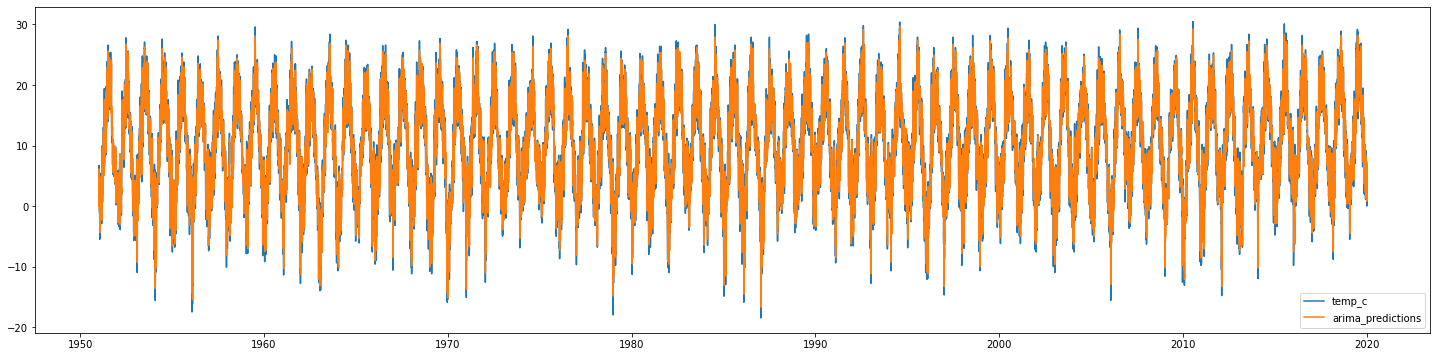

In [169]:
plt.plot(data_train['temp_c'], label='temp_c')
plt.plot(model.predict(), label='arima_predictions')  # this is called in-sample predictions, predictions on test data
plt.legend()

plt.show()

In [163]:
data_train

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,,
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0.256522,2.243478,-11.686035,-4.353623,-1.424733
1951-01-06,4.4,1951,1,January,6,0,0,0,0,1,...,0,0,0,0,0,-0.062319,4.462319,-4.026039,-2.095652,-0.871604
1951-01-07,5.0,1951,1,January,7,0,0,0,0,0,...,0,0,0,0,0,-0.036232,5.036232,-20.140637,-1.642029,-0.670340
1951-01-08,3.3,1951,1,January,8,0,0,0,0,0,...,0,0,0,0,0,0.357971,2.942029,0.044489,0.236232,0.449198
1951-01-09,3.8,1951,1,January,9,0,0,0,0,0,...,0,0,0,0,0,0.424638,3.375362,8.555126,2.243478,1.291010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.1,2019,12,December,361,0,0,0,0,0,...,0,0,0,0,0,1.652174,1.447826,9.157182,5.120290,3.629495
2019-12-28,1.3,2019,12,December,362,0,0,0,0,0,...,1,0,0,0,0,1.697101,-0.397101,-9.144273,4.517391,3.441599
2019-12-29,0.0,2019,12,December,363,0,0,0,0,0,...,0,1,0,0,0,1.114493,-1.114493,-4.532187,3.527536,2.476734


In [164]:
seasonal_dummies

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
1951-01-05,0,0,0,0,0,0,0,0,0,0,0
1951-01-06,0,0,0,0,0,0,0,0,0,0,0
1951-01-07,0,0,0,0,0,0,0,0,0,0,0
1951-01-08,0,0,0,0,0,0,0,0,0,0,0
1951-01-09,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,0,0,0,0,0,0,0,0,0,0,1


In [125]:
#remove 29.02 in leap years
data_train = data_train[~((data_train.index.month == 2) & (data_train.index.day == 29))]

In [173]:
#model the seasonality
seasonal_dummies = pd.get_dummies(data_train.index.dayofyear,
                                  prefix='day_of_year',
                                  drop_first=True).set_index(data_train.index)

#data_train = data_train.join(seasonal_dummies)
#data_train.index = pd.DatetimeIndex(data_train.index).to_period('D')

In [174]:
# exog in statsmodels ARIMA is the same as X in any sklearn model

model_season = ARIMA(data_train['temp_c'], order=(0,1,8), exog=seasonal_dummies).fit()

#freq = 'd'

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [145]:
data_train['temp_c']

date
1951-01-05    2.5
1951-01-06    4.4
1951-01-07    5.0
1951-01-08    3.3
1951-01-09    3.8
             ... 
2019-12-27    3.1
2019-12-28    1.3
2019-12-29    0.0
2019-12-30    4.5
2019-12-31    6.0
Name: temp_c, Length: 25181, dtype: float64

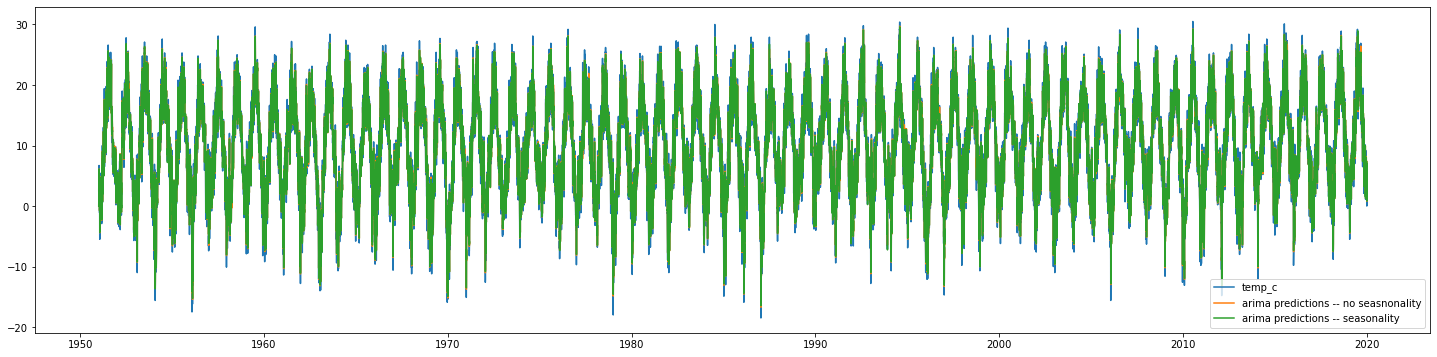

In [128]:
plt.plot(data_train['temp_c'], label='temp_c')
plt.plot(model.predict(), label='arima predictions -- no seasnonality')
plt.plot(model_season.predict(), label='arima predictions -- seasonality')
plt.legend()

plt.show()

In [129]:
rmse_no_seasonality = np.sqrt(mean_squared_error(data_train['temp_c'], model.predict()))

rmse_seasonality = np.sqrt(mean_squared_error(data_train['temp_c'], model_season.predict()))

In [130]:
rmse_no_seasonality, rmse_seasonality

(2.2861444724001214, 2.2822277244493705)

In [131]:
# R squared score
print(r2_score(data_train['temp_c'], model.predict()))  

print(r2_score(data_train['temp_c'], model_season.predict())) 

0.9162176767299809
0.9165045117406482


## Prediction test data

In [132]:
data_test = pd.read_csv('temp_test.csv', parse_dates=True, index_col=0)

In [133]:
data_test

,temp_c
date,
2020-01-01,2.7
2020-01-02,0.9
2020-01-03,4.6
2020-01-04,4.2
2020-01-05,1.8
...,...
2020-12-27,1.6
2020-12-28,2.8
2020-12-29,2.3


In [134]:
data_train

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,,
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0.256522,2.243478,-11.686035,-4.353623,-1.424733
1951-01-06,4.4,1951,1,January,6,0,0,0,0,1,...,0,0,0,0,0,-0.062319,4.462319,-4.026039,-2.095652,-0.871604
1951-01-07,5.0,1951,1,January,7,0,0,0,0,0,...,0,0,0,0,0,-0.036232,5.036232,-20.140637,-1.642029,-0.670340
1951-01-08,3.3,1951,1,January,8,0,0,0,0,0,...,0,0,0,0,0,0.357971,2.942029,0.044489,0.236232,0.449198
1951-01-09,3.8,1951,1,January,9,0,0,0,0,0,...,0,0,0,0,0,0.424638,3.375362,8.555126,2.243478,1.291010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.1,2019,12,December,361,0,0,0,0,0,...,0,0,0,0,0,1.652174,1.447826,9.157182,5.120290,3.629495
2019-12-28,1.3,2019,12,December,362,0,0,0,0,0,...,1,0,0,0,0,1.697101,-0.397101,-9.144273,4.517391,3.441599
2019-12-29,0.0,2019,12,December,363,0,0,0,0,0,...,0,1,0,0,0,1.114493,-1.114493,-4.532187,3.527536,2.476734


In [135]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp_c  366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [136]:
#remove 29.02 in leap years
data_test = data_test[~((data_test.index.month == 2) & (data_test.index.day == 29))]

In [137]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp_c  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [141]:
data_train

,temp_c,year,month,month_name,day_of_year,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,day_of_year_362,day_of_year_363,day_of_year_364,day_of_year_365,day_of_year_366,trend_seasonal,remainder,random,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,,
1951-01-05,2.5,1951,1,January,5,0,0,0,1,0,...,0,0,0,0,0,0.256522,2.243478,-11.686035,-4.353623,-1.424733
1951-01-06,4.4,1951,1,January,6,0,0,0,0,1,...,0,0,0,0,0,-0.062319,4.462319,-4.026039,-2.095652,-0.871604
1951-01-07,5.0,1951,1,January,7,0,0,0,0,0,...,0,0,0,0,0,-0.036232,5.036232,-20.140637,-1.642029,-0.670340
1951-01-08,3.3,1951,1,January,8,0,0,0,0,0,...,0,0,0,0,0,0.357971,2.942029,0.044489,0.236232,0.449198
1951-01-09,3.8,1951,1,January,9,0,0,0,0,0,...,0,0,0,0,0,0.424638,3.375362,8.555126,2.243478,1.291010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.1,2019,12,December,361,0,0,0,0,0,...,0,0,0,0,0,1.652174,1.447826,9.157182,5.120290,3.629495
2019-12-28,1.3,2019,12,December,362,0,0,0,0,0,...,1,0,0,0,0,1.697101,-0.397101,-9.144273,4.517391,3.441599
2019-12-29,0.0,2019,12,December,363,0,0,0,0,0,...,0,1,0,0,0,1.114493,-1.114493,-4.532187,3.527536,2.476734


In [138]:
model_season.predict()

date
1951-01-05    0.000000
1951-01-06    2.500000
1951-01-07    4.461309
1951-01-08    4.671031
1951-01-09    2.963853
                ...   
2019-12-27    4.954159
2019-12-28    3.270311
2019-12-29    1.921556
2019-12-30    0.833625
2019-12-31    5.289671
Name: predicted_mean, Length: 25181, dtype: float64

In [143]:
data_train.shape

(25181, 375)

In [139]:
model.forecast()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


25181    5.693211
dtype: float64

In [188]:
# data_test['predictions'] = model.predict(start=25181 , end=25191).values
# data_test['predictions_season'] =  model_season.predict(start=25181, 
#                                                            end=25191, exog=seasonal_dummies.iloc[0:365])

In [184]:
# add predictions from both models

data_test['predictions'] = model.predict(start='2020-01-01', end='2020-12-31').values

#data_test['predictions'] = model.predict(start=datetime(2020, 1, 1), end=datetime(2020, 12, 31).values

data_test['predictions_season'] =  model_season.predict(start='2020-01-01', 
                                                           end='2020-12-31', exog=seasonal_dummies.iloc[0:365])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [176]:
#model.predict(start=datetime(2020, 1, 1), end=datetime(2020, 12, 31), freq='D')

In [177]:
data_test

,temp_c
date,
2020-01-01,2.7
2020-01-02,0.9
2020-01-03,4.6
2020-01-04,4.2
2020-01-05,1.8
...,...
2020-12-27,1.6
2020-12-28,2.8
2020-12-29,2.3
